In [1]:
#purpose is to take HST images and identify extended sources (HH objects in our case)

#just to check python version - should be 3.7.4
from platform import python_version
print(python_version())

#importing astro libraries
from astropy.io import fits
from astropy.convolution import convolve, Gaussian2DKernel, Box2DKernel
from astropy.nddata import Cutout2D
from astropy.wcs import WCS

#importing general tools
import glob
import itertools
import matplotlib 
matplotlib.use('Agg') #invokved b/c just plain matplotlib was insufficient
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

%matplotlib inline

3.8.13


C:\Users\arubi\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# #finding the path to every fits images in a directory
def im_name_finder(path, file_type):
    #Using glob (it's a unix command similar to ls)
    #WARNING: using recursive=True...depending how many images you use this could be very slow, it's recommended not to have too many subfolders
    #if needed, some example code is commented towards the latter half of this code that could help make an alternative
    all_names = glob.glob(path, recursive=True)

    #IMPORTANT: Using "fit" here because it is inclusive of both fits and FIT...some files end in "FIT" and need to be included
    #using s.lower() include uppercase names
    im_names = [s for s in all_names if 'fit' in s.lower()]

    return im_names

# In[27]:

#setting up a new fits file to be saved and viewed in DS9
#primarily to save the image we reprojected, but can also be used to save the convolved images
def fits_saver(array, wcs_header, name, save_path):
    '''
    array is a 2d array of data - could be from reprojecting one image onto another or from convolution
    wcs_header is a header containing the wcs coords of the image that we projected onto or of the orig image (if from the convolution)
    name is the path to some image you're using. It will get string split at the / character, and the func only takes the last element of that splitting
    save_path is the folder you want to save to...recommended to also add something to the start of the images names to make it clear what you did to them (e.g. 'Regridded/regrid_')
    '''

    #creating a new file and adding the reprojected array of data as well as the WCS that we projected onto
    hdu_new = fits.PrimaryHDU(array, header=wcs_header)
    hdul = fits.HDUList([hdu_new])
    
    #saving the file
    if name.find('FIT') == -1: #needed if file end incorrect
        new_filename = name.split('/')[-1]  #grabs the file name we were using from before
        hdul.writeto(save_path+new_filename, overwrite=True)
    else:
        name_fixfit = name[:-3] + 'fits'
        new_filename = name_fixfit.split('/')[-1]  #grabs the file name we were using from before
        hdul.writeto(save_path+new_filename, overwrite=True)
        
    return (save_path+new_filename)

In [3]:
# path = '../../Montage_results/n2071_headercut/*drz.fits' # #using ** will grab all files even in subdirectories WARNING takes longer
# im_names_n2071 = sorted(im_name_finder(path, 'fit')) #im_finder is basically glob.glob
# im_names_n2071 = [i.replace('\\', '/') for i in im_names_n2071]
im_names_n2071 = ['../scaling_for_motions/160_epoch1_scaled.fits', '../scaling_for_motions/160_epoch2_synth_scaled.fits']

print(im_names_n2071)

# path = '../../Montage_results/n2071_headercut/*drz.fits' # #using ** will grab all files even in subdirectories WARNING takes longer
# im_names_n2071 = sorted(im_name_finder(path, 'fit')) #im_finder is basically glob.glob
# im_names_n2071 = [i.replace('\\', '/') for i in im_names_n2071]
# print(im_names_n2071)

hdu_list = [fits.open(i) for i in im_names_n2071]

#initializing some lists to be used
hdu_pix_list = []
hdu_pixtorad_list = []
# hdu_fnu_list = []
hdu_lam_list = []
# hdu_flam_list = []
# hdu_bw_list = []
hdu_data_list = []
hdu_header_list = []

count = 0
for hdu_data in hdu_list:   
    #reading in data for general use  and header for wcs
    #converting by times by flam * bw from e-/sec...should get units of erg/cm^2/sec as above
    hdu_data_list.append(hdu_data[0].data) # * hdu_list[0].header['PHOTFLAM'] * hdu_list[0].header['PHOTBW'])
    hdu_header_list.append(hdu_data[0].header)
    
    count+=1

['../scaling_for_motions/160_epoch1_scaled.fits', '../scaling_for_motions/160_epoch2_synth_scaled.fits']


# SIFT

[]


C:\Users\arubi\AppData\Local\Temp\ipykernel_21992\2052831585.py:22: RuntimeWarning: divide by zero encountered in log10
  plt_match = plot_matches(ax, np.log10(img1), np.log10(-img2), keypoints1, keypoints2, matches12)
C:\Users\arubi\AppData\Local\Temp\ipykernel_21992\2052831585.py:22: RuntimeWarning: invalid value encountered in log10
  plt_match = plot_matches(ax, np.log10(img1), np.log10(-img2), keypoints1, keypoints2, matches12)


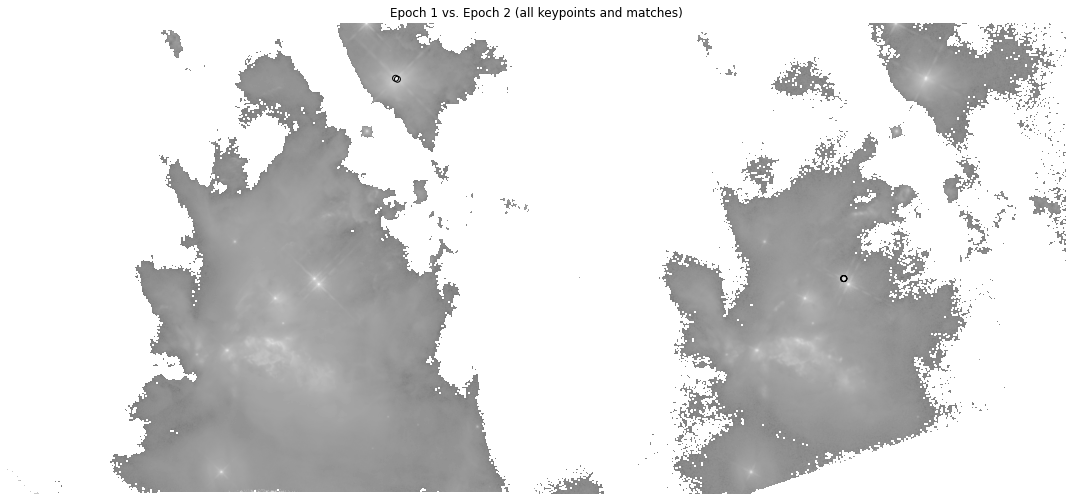

In [80]:
from skimage.feature import match_descriptors, plot_matches, SIFT

descriptor_extractor = SIFT()

img1 = hdu_data_list[0]
img2 = -hdu_data_list[1]

descriptor_extractor.detect_and_extract(img1)
keypoints1 = descriptor_extractor.keypoints
descriptors1 = descriptor_extractor.descriptors

descriptor_extractor.detect_and_extract(img2)
keypoints2 = descriptor_extractor.keypoints
descriptors2 = descriptor_extractor.descriptors

matches12 = match_descriptors(descriptors1, descriptors2, max_ratio=0.8,cross_check=True)

print(matches12)

fig, ax = plt.subplots(figsize=(15, 15))
plt.gray()
plt_match = plot_matches(ax, np.log10(img1), np.log10(-img2), keypoints1, keypoints2, matches12)
ax.axis('off')
ax.set_title("Epoch 1 vs. Epoch 2 (all keypoints and matches)")
plt.tight_layout()
plt.show()

# BRIEF

In [78]:
from skimage.feature import (corner_peaks, corner_harris, BRIEF)

keypoints1 = corner_peaks(corner_harris(img1), min_distance=1,threshold_rel=None)
keypoints2 = corner_peaks(corner_harris(img2), min_distance=1,threshold_rel=None)

print(keypoints1, keypoints2)

extractor = BRIEF()

extractor.extract(img1, keypoints1)
keypoints1 = keypoints1[extractor.mask]
descriptors1 = extractor.descriptors

extractor.extract(img2, keypoints2)
keypoints2 = keypoints2[extractor.mask]
descriptors2 = extractor.descriptors

matches12 = match_descriptors(descriptors1, descriptors2, cross_check=True)

fig, ax = plt.subplots(figsize=(15, 15))
plt.gray()
plot_matches(ax, img1, img2, keypoints1, keypoints2, matches12)
ax.axis('off')
ax.set_title("Epoch 1 vs Epoch 2")

[[117 833]
 [557 665]
 [  1 768]
 ...
 [144 834]
 [126 855]
 [128 814]] []


TypeError: Invalid call to pythranized function `_brief_loop(float64[:, :], uint8[:, :] (reshaped), int64[:, :] (strided), int32[:, :] (reshaped), int32[:, :] (reshaped))'
Candidates are:

    - _brief_loop(float32[:,:], uint8[:,:], int64[:,2], int32[:,2], int32[:,2])
    - _brief_loop(float64[:,:], uint8[:,:], int64[:,2], int32[:,2], int32[:,2])


# ORB

C:\Users\arubi\AppData\Local\Temp\ipykernel_21992\1791455016.py:20: RuntimeWarning: divide by zero encountered in log10
  plot_matches(ax, np.log10(img1), np.log10(img2), keypoints1, keypoints2, matches12)
C:\Users\arubi\AppData\Local\Temp\ipykernel_21992\1791455016.py:20: RuntimeWarning: invalid value encountered in log10
  plot_matches(ax, np.log10(img1), np.log10(img2), keypoints1, keypoints2, matches12)


Text(0.5, 1.0, 'Original Image vs. Transformed Image')

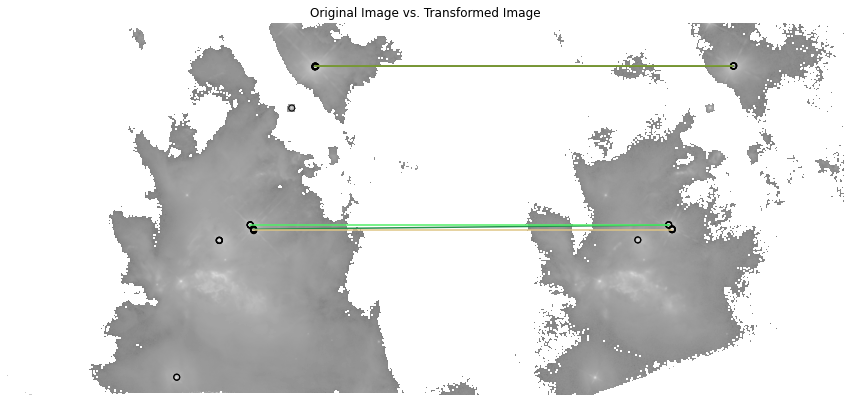

In [131]:
from skimage.feature import ORB

img1 = hdu_data_list[0]
img2 = hdu_data_list[1]

descriptor_extractor = ORB(n_keypoints=100)

descriptor_extractor.detect_and_extract(img1)
keypoints1 = descriptor_extractor.keypoints
descriptors1 = descriptor_extractor.descriptors

descriptor_extractor.detect_and_extract(img2)
keypoints2 = descriptor_extractor.keypoints
descriptors2 = descriptor_extractor.descriptors

matches12 = match_descriptors(descriptors1, descriptors2, cross_check=True)

fig, ax = plt.subplots(figsize=(15, 15))
plt.gray()
plot_matches(ax, np.log10(img1), np.log10(img2), keypoints1, keypoints2, matches12)
ax.axis('off')
ax.set_title("Original Image vs. Transformed Image")

# CENSURE

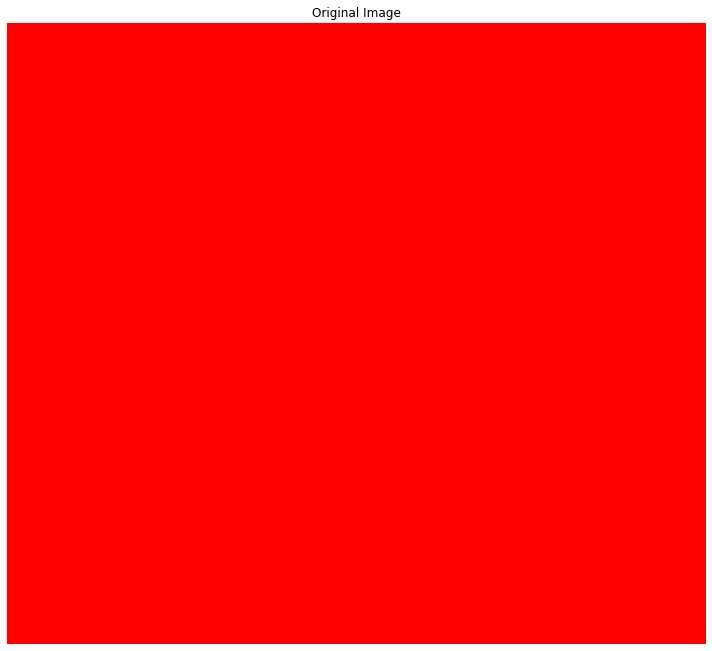

In [143]:
from skimage.feature import CENSURE
detector = CENSURE(max_scale=30, non_max_threshold=0)
detector.detect(img1)

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(img1, cmap=plt.cm.gray, vmin=0, vmax=np.max(img1)*3e-4)
ax.scatter(detector.keypoints[:, 1], detector.keypoints[:, 0], 2 ** detector.scales, facecolors='none', edgecolors='r')
ax.set_title("Original Image")
ax.axis('off')
plt.tight_layout()
plt.show()

In [144]:
detector.keypoints

array([[   0,    0],
       [   0,    0],
       [   0,    0],
       ...,
       [1005, 1130],
       [1005, 1130],
       [1005, 1130]], dtype=int64)

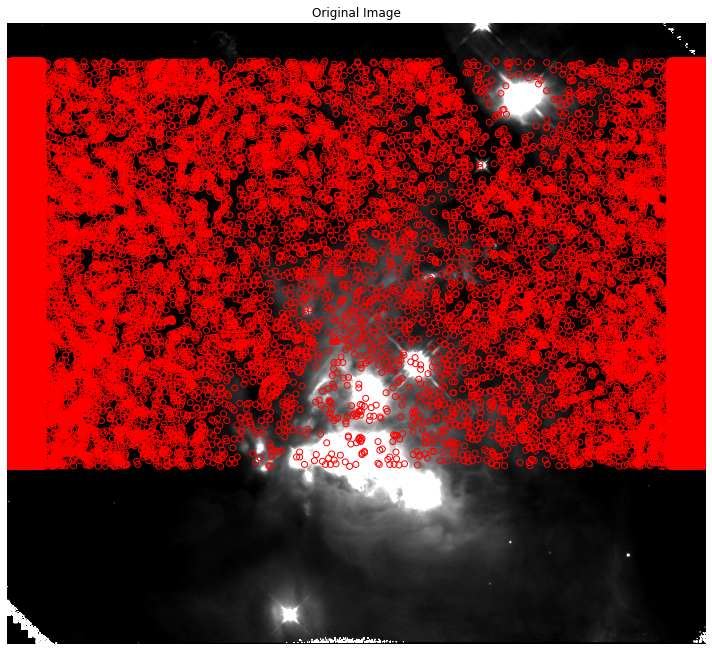

In [162]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(img1, cmap=plt.cm.gray, vmin=0, vmax=np.max(img1)*3e-4)
ax.scatter(detector.keypoints[1000000:2000000, 1], detector.keypoints[1000000:2000000, 0], facecolors='none', edgecolors='r')
ax.set_title("Original Image")
ax.axis('off')
plt.tight_layout()
plt.show()

In [158]:
len(detector.keypoints)

3332872